取引価格（総額）_log    1.000000
建築年             0.699559
面積（㎡）           0.410799
取引時点            0.083543
市区町村コード        -0.085983
最寄駅：距離（分）      -0.161079
Name: 取引価格（総額）_log, dtype: float64


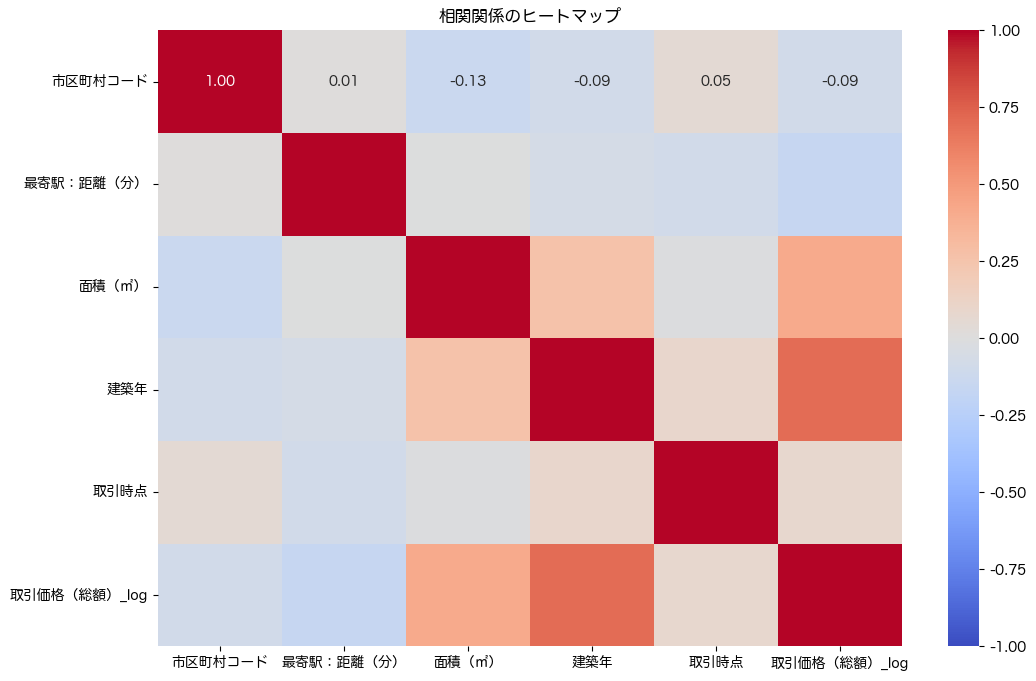

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned3/combined_data_21_24_25_29_30_33_最寄駅_面積（㎡）_建築年_取引時点_取引価格（総額）_log.csv'
data_cleaned = pd.read_csv(data_path)

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# '間取り'と'建物の構造'列を除外
data_numeric = data_cleaned.drop(columns=['間取り', '建物の構造'])

# 数値列の相関関係を計算
correlation_matrix = data_numeric.corr()

# '取引価格（総額）_log'との相関が高い列を取得
correlation_with_price = correlation_matrix['取引価格（総額）_log'].sort_values(ascending=False)

# 相関関係の確認
print(correlation_with_price)

# ヒートマップの作成
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('相関関係のヒートマップ')
plt.show()
  


特徴量を作成する

In [2]:
import pandas as pd
import numpy as np

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned3/combined_data_21_24_25_29_30_33_最寄駅_面積（㎡）_建築年_取引時点_取引価格（総額）_log.csv'
data_cleaned = pd.read_csv(data_path)

# 築年数を計算
data_cleaned['築年数'] = 2024 - data_cleaned['建築年']

# 面積/築年数比を計算
data_cleaned['面積/築年数比'] = data_cleaned['面積（㎡）'] / data_cleaned['築年数']

# 価格/面積比を計算
data_cleaned['価格/面積比'] = data_cleaned['取引価格（総額）_log'] / data_cleaned['面積（㎡）']

# 取引時点から年を抽出
data_cleaned['取引年'] = data_cleaned['取引時点'].astype(str).str[:4].astype(int)

# 新しい特徴量の作成
data_cleaned['築年数の二乗'] = data_cleaned['築年数'] ** 2
data_cleaned['面積×築年数'] = data_cleaned['面積（㎡）'] * data_cleaned['築年数']

# 取引時点を年と月に分割
data_cleaned['取引年'] = data_cleaned['取引時点'].apply(lambda x: int(str(x)[:4]))
data_cleaned['取引月'] = data_cleaned['取引時点'].apply(lambda x: int(str(x)[4:6]))

# 駅距離の統計情報を確認
print(data_cleaned['最寄駅：距離（分）'].describe())

# 駅距離を次のように分割して数値に対応付け
bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
numeric_labels = [1, 2, 3, 4, 5, 6, 7]
data_cleaned['駅距離_分範囲'] = pd.cut(data_cleaned['最寄駅：距離（分）'], bins=bins, labels=numeric_labels)

# エリア人気度スコアの計算
area_popularity = data_cleaned.groupby('市区町村コード')['取引価格（総額）_log'].mean().reset_index()
area_popularity.columns = ['市区町村コード', 'エリア人気度スコア']
data_cleaned = data_cleaned.merge(area_popularity, on='市区町村コード', how='left')

# 年別価格トレンドの計算
yearly_trend = data_cleaned.groupby('取引年')['取引価格（総額）_log'].mean().reset_index()
yearly_trend.columns = ['取引年', '年別価格トレンド']
data_cleaned = data_cleaned.merge(yearly_trend, on='取引年', how='left')

# 価格増加率の計算
data_cleaned = data_cleaned.sort_values(by='取引時点')
data_cleaned['価格増加率'] = data_cleaned['取引価格（総額）_log'].pct_change()
data_cleaned['価格増加率'].fillna(0, inplace=True)

# 新しい特徴量を含むデータの確認
print(data_cleaned.head())

# データを保存
data_cleaned_path = '/Users/hayakawakazue/Downloads/data/train/train_cleaned4/combined_data_21_24_25_29_30_33_cleaned_with_features.csv'
data_cleaned.to_csv(data_cleaned_path, index=False)

print(f"データを保存しました: {data_cleaned_path}")

print(data_cleaned.dtypes)


count    14310.000000
mean        13.991614
std         12.148466
min          0.000000
25%          6.000000
50%         10.000000
75%         18.000000
max         45.000000
Name: 最寄駅：距離（分）, dtype: float64
      市区町村コード  最寄駅：距離（分）   間取り  面積（㎡）     建築年 建物の構造      取引時点  取引価格（総額）_log  \
1250    21201       45.0  ４ＬＤＫ   70.0  1981.0   ＳＲＣ  200509.0      7.079181   
121     21201       45.0  ４ＬＤＫ   80.0  1997.0   ＳＲＣ  200509.0      7.079181   
1270    21201       45.0  ４ＬＤＫ   70.0  2001.0    ＲＣ  200509.0      7.380211   
1105    21201       45.0  ３ＬＤＫ   80.0  1992.0   ＳＲＣ  200509.0      7.113943   
533     21201       29.0  ３ＬＤＫ   65.0  1993.0   鉄骨造  200509.0      7.041393   

       築年数   面積/築年数比    価格/面積比   取引年  築年数の二乗  面積×築年数  取引月 駅距離_分範囲  エリア人気度スコア  \
1250  43.0  1.627907  0.101131  2005  1849.0  3010.0    9       7   7.151617   
121   27.0  2.962963  0.088490  2005   729.0  2160.0    9       7   7.151617   
1270  23.0  3.043478  0.105432  2005   529.0  1610.0    9       7   7.151617 